Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [4]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

In [6]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [9]:
train.shape, test.shape,

((59400, 41), (14358, 40))

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [12]:
def wrangle(X):
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    # Drop duplicates and non-useful
    drops = ['quantity_group', 'payment_type','recorded_by', 'id']
    X = X.drop(#Wrangle train, validate, and test sets in the same way
columns=drops)
    # Convert date_recorded to datetime to give months, days, and years seperate columns
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year'] = X['date_recorded'].dt.year
    X['month'] = X['date_recorded'].dt.month
    X['day'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    # Engineer feature: age at time of recording
    X['age'] = X['year'] - X['construction_year']
    cols_w0 = ['longitude', 'latitude', 'construction_year','gps_height', 'population','age']
    for col in cols_w0:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


In [13]:
target = 'status_group'
#Create a list to check cardinality
cardinality = train.select_dtypes(exclude='number').nunique()
# eliminate all cardinalities of over 50 
categorical_drops = cardinality[cardinality > 50].index.tolist()
train_features = train.columns.drop(target)
features = train_features.drop(categorical_drops)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

#check all of our dimensions match up.
X_train.shape, y_train.shape[0], X_val.shape, y_val.shape[0], X_test.shape

((51678, 38), 51678, (7722, 38), 7722, (14358, 38))

In [17]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=17, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8144263144263144


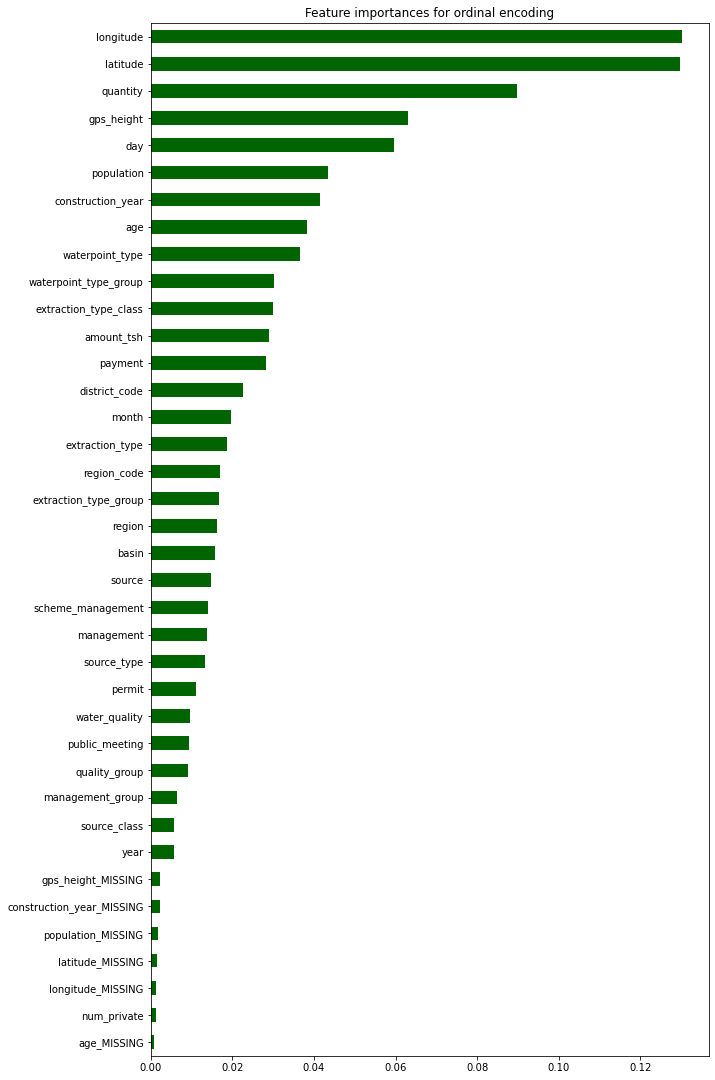

In [19]:
# feature_importances_ as a chart
feat_imp = pd.Series(pipeline.named_steps['randomforestclassifier'].feature_importances_,X_train.columns)
plt.figure(figsize=(10,(len(feat_imp)/2)))
plt.title('Feature importances for ordinal encoding')
feat_imp.sort_values().plot.barh(color='darkgreen');

In [21]:
y_pred = pipeline.predict(X_val)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[3736,  132,  326],
       [ 279,  191,   91],
       [ 558,   47, 2362]], dtype=int64)

In [24]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [25]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,3736,132,326
Actual functional needs repair,279,191,91
Actual non functional,558,47,2362


In [26]:
#heatmap
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')


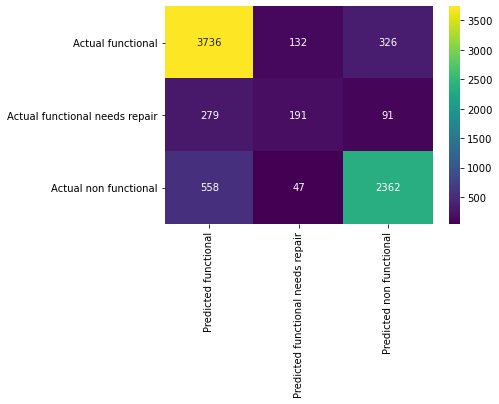

In [28]:
plot_confusion_matrix(y_val,y_pred)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.89      0.85      4194
functional needs repair       0.52      0.34      0.41       561
         non functional       0.85      0.80      0.82      2967

               accuracy                           0.81      7722
              macro avg       0.73      0.68      0.69      7722
           weighted avg       0.81      0.81      0.81      7722

